<a href="https://colab.research.google.com/github/abelshinev/fit_forecaster/blob/main/Fit_Forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Statements**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

file_path = r'/tuegym.csv'
df = pd.read_csv(file_path)
df

,id,first_name,gender,Age,visit_per_week,fav_group_lesson,avg_time_check_in,avg_time_check_out,avg_time_in_gym,Tue
0,2,Doralin,Female,33,4,NaN,19:31:00,21:55:00,128,True
1,4,Darren,Male,42,1,NaN,09:54:00,12:00:00,95,True
2,5,Petr,Male,32,2,Running,08:29:00,09:48:00,97,True
3,7,Anson,Male,36,5,Cardio,19:46:00,20:59:00,30,True
4,16,Katya,Female,45,4,"leg, Core",17:28:00,19:02:00,65,True
...,...,...,...,...,...,...,...,...,...,...
1950,4990,Clywd,Male,18,3,NaN,11:50:00,13:07:00,38,True
1951,4991,Oliy,Female,37,2,NaN,08:22:00,11:11:00,61,True
1952,4993,Melantha,Female,25,2,"Running, Cardio, leg",09:42:00,10:49:00,172,True
1953,4994,Averill,Male,37,4,"Cardio, Arm",19:50:00,20:24:00,136,True


# **Data Preprocessing**

In [ ]:
# Convert to float hours if not already in float format
if df['avg_time_check_in'].dtype == 'object':
    df['avg_time_check_in'] = pd.to_datetime(df['avg_time_check_in'], format='%H:%M:%S')
    df['avg_time_check_in'] = df['avg_time_check_in'].dt.hour + (df['avg_time_check_in'].dt.minute / 60)

if df['avg_time_check_out'].dtype == 'object':
    df['avg_time_check_out'] = pd.to_datetime(df['avg_time_check_out'], format='%H:%M:%S')
    df['avg_time_check_out'] = df['avg_time_check_out'].dt.hour + (df['avg_time_check_out'].dt.minute / 60)


# Set your target split
target_split = 'chest'

# Filter rows for the target split
df['is_target_split'] = df['fav_group_lesson'].fillna('').str.contains(target_split, case=False)


# Filter the data by target split
df_target = df[df['is_target_split']]
print("Preprocessing complete. Number of rows in df_target:", len(df_target))
df_target

Preprocessing complete. Number of rows in df_target: 305


,id,first_name,gender,Age,visit_per_week,fav_group_lesson,avg_time_check_in,avg_time_check_out,avg_time_in_gym,Tue,is_target_split
7,20,Abe,Male,17,4,"chest, back, Core",13.916667,16.433333,94,True,True
17,55,Chadd,Male,39,3,"leg, back, chest",15.816667,17.900000,153,True,True
27,79,Morgan,Female,40,5,"Core, Cardio, chest",12.733333,14.516667,91,True,True
31,86,Kailey,Female,15,2,"chest, Core, back",20.483333,22.866667,53,True,True
33,95,Jen,Female,40,3,"chest, leg, Cardio",10.166667,11.400000,44,True,True
...,...,...,...,...,...,...,...,...,...,...,...
1918,4929,Aldous,Male,31,5,"Cardio, chest",9.633333,11.633333,72,True,True
1921,4933,Tiertza,Female,27,3,"chest, leg, Core",19.100000,21.216667,59,True,True
1924,4936,Briano,Male,48,3,"chest, Core, back",15.516667,16.550000,108,True,True
1925,4937,Parsifal,Male,21,1,"Core, chest, Running",10.916667,11.466667,107,True,True


# **Tuesday Chunking**

In [ ]:
# Function to split dataset into non-overlapping "Tuesdays"
def create_tuesday_samples(df, k):
    """
    Splits a dataset into non-overlapping k-sized blocks.
    Each block is treated as an independent "Tuesday".

    Parameters:
    df (pd.DataFrame): DataFrame containing a single day's data.
    k (int): Number of rows per synthetic "Tuesday".
    target_column (str): Column name to be used as the target (y).

    Returns:
    list of DataFrames: Each block as a new "Tuesday".
    """
    df_values = df.to_numpy()
    num_samples = len(df_values) // k  # Non-overlapping chunks

    tuesday_blocks = []
    for i in range(num_samples):
        start_idx = i * k
        end_idx = start_idx + k
        new_tuesday = pd.DataFrame(df_values[start_idx:end_idx], columns=df.columns)
        tuesday_blocks.append(new_tuesday)

    return tuesday_blocks

k = 50


#**Data Time Setup**

In [ ]:
def bin_chunk_into_48_parts(df):
    """
    Bins a DataFrame into 48 half-hour intervals.

    Parameters:
    df (pd.DataFrame): The chunked DataFrame.

    Returns:
    pd.DataFrame: The binned DataFrame.
    """
    time_interval = 30 / 60  # Convert minutes to hours (0.5 hour bins)

    return df.groupby(
        pd.cut(df['avg_time_check_in'], bins=np.arange(0, 24.5, time_interval))
    )[['visit_per_week', 'avg_time_in_gym']].sum()



# **Setting up X and y**

In [ ]:
def df_to_X_y(df, window_size):
    """
    Converts DataFrame into sequences of features (X) and targets (y) for training/testing an LSTM.

    Parameters:
    df (pd.DataFrame): The DataFrame containing time-series data.
    window_size (int): The number of previous time steps to use for predicting the target.
    target_col (str): The column to predict (default is 'visit_per_week').

    Returns:
    X (np.array): Input features for the LSTM model.
    y (np.array): Targets for the LSTM model.
    """
    # Convert the DataFrame to a NumPy array
    df_values = df.to_numpy()

    # Initialize lists to store the sequences and targets
    X = []
    y = []
    target_col='visit_per_week'

    # Find the index of the target column
    target_index = df.columns.get_loc(target_col)

    # Loop through the NumPy array, using a sliding window approach
    for i in range(window_size, len(df_values)):
        # Collect the previous `window_size` rows as features (exclude the target column)
        selected_columns = [df.columns.get_loc('visit_per_week'), df.columns.get_loc('avg_time_in_gym')]
        X.append(df_values[i-window_size:i, selected_columns])

        # The target is the value of `target_col` at the current time step
        y.append(df_values[i, target_index])

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape X to be in the form (samples, time steps, features) for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    return X, y


# **Test**


In [ ]:
tuesday_blocks = create_tuesday_samples(df_target, k)
print("Number of Tuesdays =", len(tuesday_blocks))


# Bin each chunk
binned_blocks = [bin_chunk_into_48_parts(tuesday) for tuesday in tuesday_blocks]

for i in range(0, len(binned_blocks)):
  print("Tuesday no:", i + 1)
  print(binned_blocks[i])


# Prepare LSTM dataset
window_size = 5
X_epochs, y_epochs = [], []

for binned_tuesday in binned_blocks:
    X, y = df_to_X_y(binned_tuesday, window_size)
    if (len(X) > 0):
      X_epochs.append(X)
      y_epochs.append(y)

print(f"Prepared {len(X_epochs)} Tuesday epochs.")
print(f"Each with shape X: {X_epochs[0].shape}, y: {y_epochs[0].shape}")

print([len(tb) for tb in tuesday_blocks])


# Convert all epoch chunks to float32 to avoid dtype errors
X_epochs = [np.array(x, dtype=np.float32) for x in X_epochs]
y_epochs = [np.array(y, dtype=np.float32) for y in y_epochs]

print(X_epochs[0].dtype, y_epochs[0].dtype)

Number of Tuesdays = 6
Tuesday no: 1
                  visit_per_week avg_time_in_gym
avg_time_check_in                               
(0.0, 0.5]                     0               0
(0.5, 1.0]                     0               0
(1.0, 1.5]                     0               0
(1.5, 2.0]                     0               0
(2.0, 2.5]                     0               0
(2.5, 3.0]                     0               0
(3.0, 3.5]                     0               0
(3.5, 4.0]                     0               0
(4.0, 4.5]                     0               0
(4.5, 5.0]                     0               0
(5.0, 5.5]                     0               0
(5.5, 6.0]                     0               0
(6.0, 6.5]                     0               0
(6.5, 7.0]                     0               0
(7.0, 7.5]                     0               0
(7.5, 8.0]                     0               0
(8.0, 8.5]                     6             117
(8.5, 9.0]                     5

<ipython-input-5-d1865477885b>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(
<ipython-input-5-d1865477885b>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(
<ipython-input-5-d1865477885b>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(
<ipython-input-5-d1865477885b>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in

# Train Test Split

In [ ]:
""" DO NOT RUN """

#
# from sklearn.model_selection import train_test_split
#
#
# # Split into training (80%) and testing (20%) data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
#
# # Reshape X for LSTM input
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
#
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)
#
# X = np.array(X, dtype=np.float32)
# X_train = np.array(X_train, dtype=np.float32)
# X_test = np.array(X_test, dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
# y_test = np.array(y_test, dtype=np.float32)
#
# print(X.dtype)
# print(type(X))
# print(X.shape)
#
# print(X_test)


""" RUN """
split_index = int(len(X_epochs) * 0.8)
X_train_epochs = X_epochs[:split_index]
y_train_epochs = y_epochs[:split_index]
X_test_epochs = X_epochs[split_index:]
y_test_epochs = y_epochs[split_index:]

#**LSTM MODEL**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

"""
# Define model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(5, 2)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])
"""



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epoch_losses = list()
epoch_maes = list()

# Train over synthetic Tuesdays, one epoch per chunk

for epoch_num, (X_day, y_day) in enumerate(zip(X_epochs, y_epochs), 1):
    print(f"\n🌀 Training on synthetic Tuesday {epoch_num} with {X_day.shape[0]} samples")
    history = model.fit(X_day, y_day, epochs=10, batch_size=32, verbose=1)

    loss = history.history['loss'][0]
    mae = history.history['mae'][0]

    epoch_losses.append(loss)
    epoch_maes.append(mae)

X_test = X_test_epochs[0].astype(np.float32)
y_test = y_test_epochs[0].astype(np.float32)
y_pred = model.predict(X_test)


🌀 Training on synthetic Tuesday 1 with 43 samples
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 29.8482 - mae: 3.1544
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.2960 - mae: 2.9645
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 28.6317 - mae: 3.1840
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 28.8476 - mae: 3.3032
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 26.3763 - mae: 3.0554
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.7601 - mae: 3.0304
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.9202 - mae: 3.1492
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20.5574 - mae: 2.8127
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.0225 - mae: 3.0853
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 24.1607 - mae: 2.9738

🌀 Training on synthetic Tuesday 2 with 43 samples
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.2239 - mae: 2.9209
Epoch 2/10
2/2 ━━━━━━━━━━━━━

# **Visualiser**

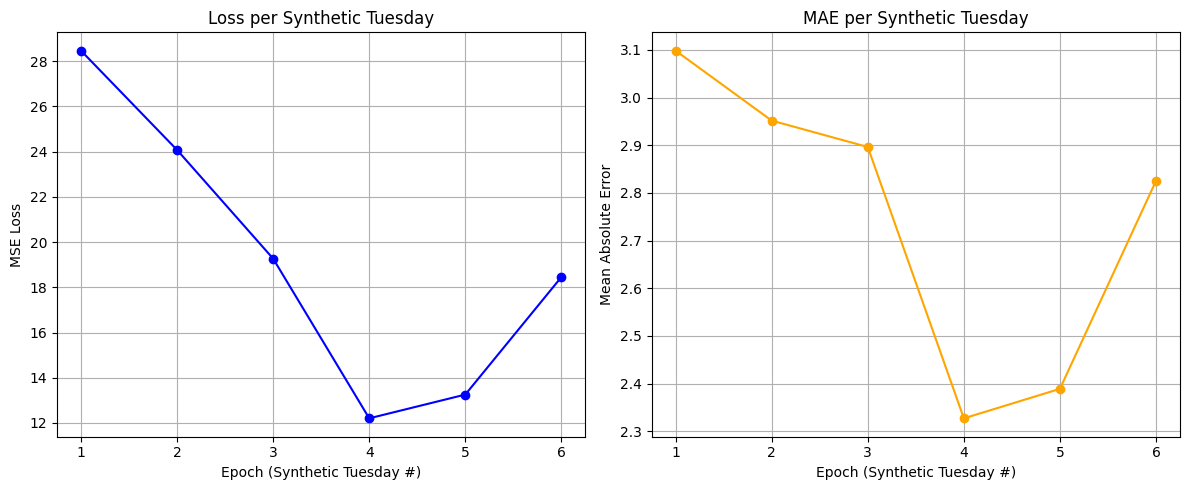

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', color='blue')
plt.title("Loss per Synthetic Tuesday")
plt.xlabel("Epoch (Synthetic Tuesday #)")
plt.ylabel("MSE Loss")
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_maes)+1), epoch_maes, marker='o', color='orange')
plt.title("MAE per Synthetic Tuesday")
plt.xlabel("Epoch (Synthetic Tuesday #)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)

plt.tight_layout()
plt.show()


#**Compare with real result**

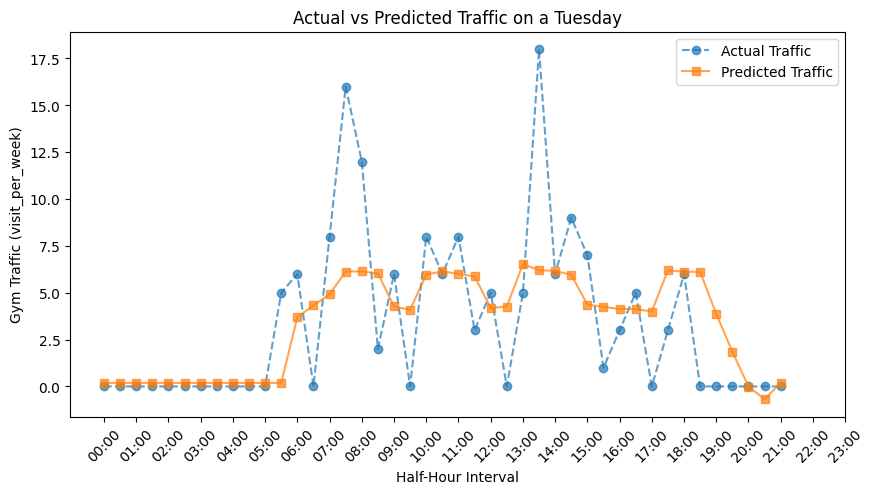

In [ ]:
time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 30)]


plt.figure(figsize=(10, 5))
plt.title("Actual vs Predicted Traffic on a Tuesday")
plt.plot(y_test, label="Actual Traffic", marker='o', linestyle='dashed', alpha=0.7)
plt.plot(y_pred, label="Predicted Traffic", marker='s', linestyle='solid', alpha=0.7)

tick_indices = np.arange(0, 48, 2)
plt.xticks(ticks=tick_indices, labels=[time_labels[i] for i in tick_indices], rotation=45)
plt.xlabel("Half-Hour Interval")
plt.ylabel("Gym Traffic (visit_per_week)")
plt.legend()